In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.core.window import Rolling
import statsmodels.api as sm 

from pmdarima.arima import auto_arima
from pmdarima import model_selection, pipeline
from pmdarima import preprocessing as ppc
from pmdarima import arima

from src.utils import test_stationarity

In [56]:
class CFG:
    data_path = "../data"
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   

In [9]:
nasdaq_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'nasdaq_ohlc_df.csv')
spy_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'spy_ohlc_df.csv')
dow_jones_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'dow_jones_ohlc_df.csv')

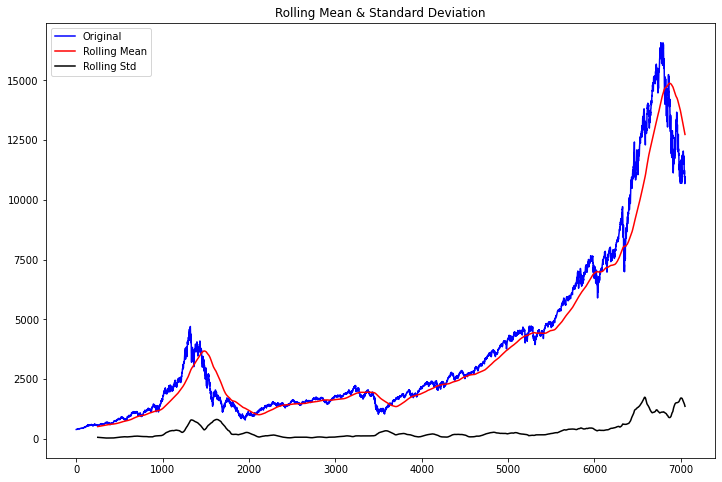

Results of Dickey-Fuller Test:
Non-stationary
Test Statistic                    0.222548
p-value                           0.973498
#Lags Used                       28.000000
Number of Observations Used    7021.000000
Critical Value (1%)              -3.431282
Critical Value (5%)              -2.861952
Critical Value (10%)             -2.566989
dtype: float64


In [63]:
test_stationarity(nasdaq_ohlc_df.Close)

In [20]:
nasdaq_ohlc_df[(nasdaq_ohlc_df['Date'] > "2023-01-01") & (nasdaq_ohlc_df['Date'] < "2023-03-31")]

,Date,Open,High,Low,Close,Adj Close,Volume
7050,2023-01-03,11038.419922,11093.099609,10770.929688,10862.639648,10862.639648,4780650000
7051,2023-01-04,10949.339844,10981.459961,10785.530273,10914.799805,10914.799805,5085380000
7052,2023-01-05,10837.250000,10842.330078,10728.259766,10741.219727,10741.219727,4764270000
7053,2023-01-06,10807.459961,11082.589844,10696.419922,11040.349609,11040.349609,5199780000
7054,2023-01-09,11133.070312,11304.839844,11085.320312,11108.450195,11108.450195,5132190000
...,...,...,...,...,...,...,...
7106,2023-03-24,12700.509766,12770.280273,12608.150391,12767.049805,12767.049805,4363650000
7107,2023-03-27,12797.900391,12839.419922,12647.940430,12673.070312,12673.070312,4330320000
7108,2023-03-28,12654.910156,12654.910156,12517.870117,12610.570312,12610.570312,4036910000
7109,2023-03-29,12768.139648,12867.320312,12734.679688,12846.030273,12846.030273,4493540000


In [23]:
nasdaq_ohlc_df = nasdaq_ohlc_df[:7050]

In [24]:
# we split the data into training and validation, leaving out the last year as holdout
xtrain, xvalid = model_selection.train_test_split(nasdaq_ohlc_df['Close'], test_size = 250)

In [27]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=250)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe.fit(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=299.59 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=82433.470, Time=19.89 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=79663.769, Time=76.71 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=85.59 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=82431.471, Time=154.10 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=78767.400, Time=108.11 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=78354.062, Time=48.81 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=78043.345, Time=54.65 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=77933.616, Time=60.90 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=283.74 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=221.94 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=77931.616, Time=57.06 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=78041.345, Time=54.29 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=226.14 sec
 ARIMA(4,2,1)(0,0,0)[0]      

Pipeline(steps=[('fourier', FourierFeaturizer(m=250)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

In [55]:
# we can inspect the results
# pipe.summary()

In [29]:
# we compute predictions from the pipeline object
preds, conf_int = pipe.predict(n_periods= xvalid.shape[0], return_conf_int=True)
print("\nForecasts:")
print(preds)


Forecasts:
6800    16496.654498
6801    16522.030408
6802    16518.646542
6803    16532.376163
6804    16565.201349
            ...     
7045    20149.776534
7046    20166.614903
7047    20159.594027
7048    20172.438136
7049    20193.407665
Length: 250, dtype: float64


<AxesSubplot:>

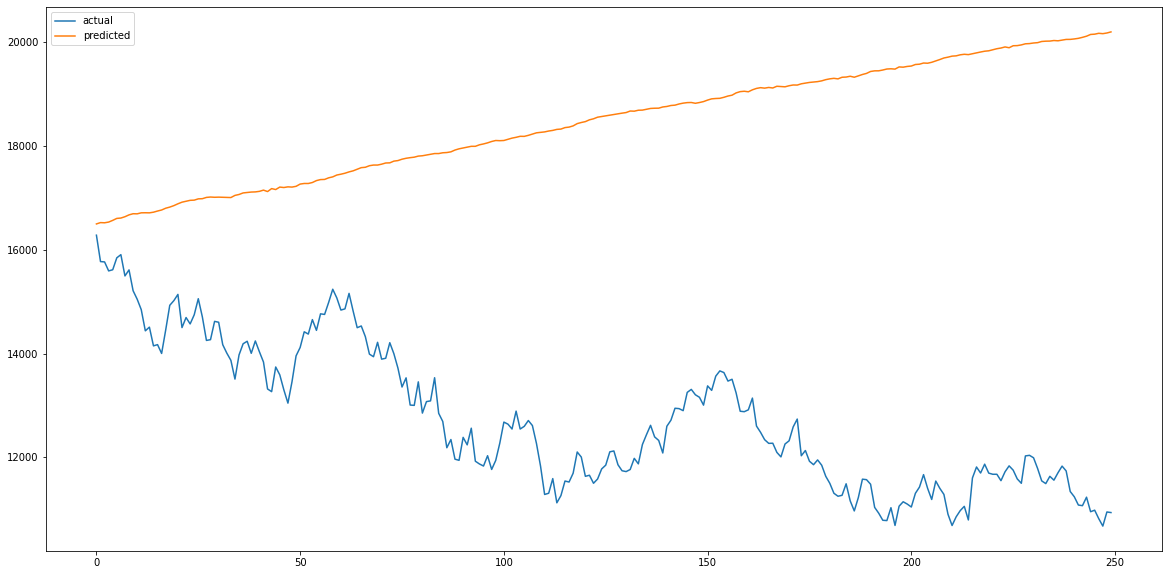

In [59]:
# let's quickly visualize the forecast
xvalid = pd.DataFrame(xvalid, columns = ['actual'])
xvalid['predicted'] = preds.reset_index(drop=True)
xvalid.plot()

In [48]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe2 = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=5)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe2.fit(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=13.93 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=82170.292, Time=0.27 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=79391.119, Time=0.71 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=82168.293, Time=3.41 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=78508.796, Time=1.60 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=78090.908, Time=1.94 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=77779.830, Time=2.73 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=77668.149, Time=2.29 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=15.02 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=16.07 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=77666.149, Time=1.88 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=77777.830, Time=1.72 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=11.51 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf

Pipeline(steps=[('fourier', FourierFeaturizer(m=5)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

In [60]:
# we can inspect the results
pipe2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6800
Model:               SARIMAX(5, 2, 0)   Log Likelihood              -38823.075
Date:                Wed, 10 May 2023   AIC                          77666.149
Time:                        17:56:25   BIC                          77734.393
Sample:                             0   HQIC                         77689.700
                               - 6800                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
FOURIER_S5-0    -0.0347      1.064     -0.033      0.974      -2.120       2.051
FOURIER_C5-0     0.1284      1.037      0.124      0.901      -1.905       2.162
FOURIER_S5-1    -0.4357      0.706     -0.617      0.537      -1.820       0.949
FOURIER_C5-1    -1.3178      0.709     -1.860      0.063      -2.707       0.071
ar.L1           -0.9469      0.004   -224.568      0.000      -0.955      -0.939
ar.L2           -0.7108      0.006   -114.039      0.000      -0.723      -0.699
ar.L3           -0.5134      0.007    -74.959      0.000      -0.527      -0.500
ar.L4           -0.3307      0.006    -51.147      0.000      -0.343      -0.318
ar.L5           -0.1290      0.004    -30.577      0.000      -0.137      -0.121
sigma2        5348.6742     28.715    186.269      0.000    5292.394    5404.954
===================================================================================
Ljung-Box (L1) (Q):                   6.64   Jarque-Bera (JB):            132710.78
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               3.70   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
# we compute predictions from the pipeline object
preds2, conf_int2 = pipe2.predict(n_periods= xvalid.shape[0], return_conf_int=True)
print("\nForecasts:")
print(preds2)


Forecasts:
6800    16493.267910
6801    16492.369675
6802    16493.242904
6803    16496.877923
6804    16515.673972
            ...     
7045    19450.417418
7046    19461.636960
7047    19473.004790
7048    19487.458708
7049    19497.028884
Length: 250, dtype: float64


In [97]:
xvalid

,actual,predicted2,confidence lower bound,confidence upper bound
0,16279.730469,16493.267910,16349.926668,16636.609152
1,15771.780273,16492.369675,16284.204372,16700.534979
2,15765.360352,16493.242904,16214.622896,16771.862912
3,15592.190430,16496.877923,16143.657119,16850.098726
4,15614.429688,16515.673972,16080.276389,16951.071555
...,...,...,...,...
245,10985.450195,19450.417418,-69630.976464,108531.811300
246,10822.509766,19461.636960,-70158.841667,109082.115588
247,10679.339844,19473.004790,-70687.641656,109633.651236
248,10951.049805,19487.458708,-71214.436462,110189.353878


In [73]:
conf_int2[:, :]

array([[ 16636.6091517 ],
       [ 16700.53497942],
       [ 16771.862912  ],
       [ 16850.09872647],
       [ 16951.07155542],
       [ 17070.51740083],
       [ 17177.61882206],
       [ 17292.66145115],
       [ 17416.40441867],
       [ 17542.41308073],
       [ 17679.3784195 ],
       [ 17816.68555666],
       [ 17957.8315555 ],
       [ 18107.07871079],
       [ 18255.89159533],
       [ 18413.65654559],
       [ 18572.37817061],
       [ 18734.98230043],
       [ 18904.53540613],
       [ 19073.0137123 ],
       [ 19249.73894154],
       [ 19427.07587171],
       [ 19608.01770751],
       [ 19795.45946883],
       [ 19981.38168925],
       [ 20175.18690445],
       [ 20369.27494279],
       [ 20566.67845982],
       [ 20770.28431012],
       [ 20972.07541584],
       [ 21181.47768448],
       [ 21390.91025323],
       [ 21603.41874571],
       [ 21821.89938614],
       [ 22038.34238753],
       [ 22262.18405625],
       [ 22485.85392704],
       [ 22712.40616836],
       [ 229

<AxesSubplot:>

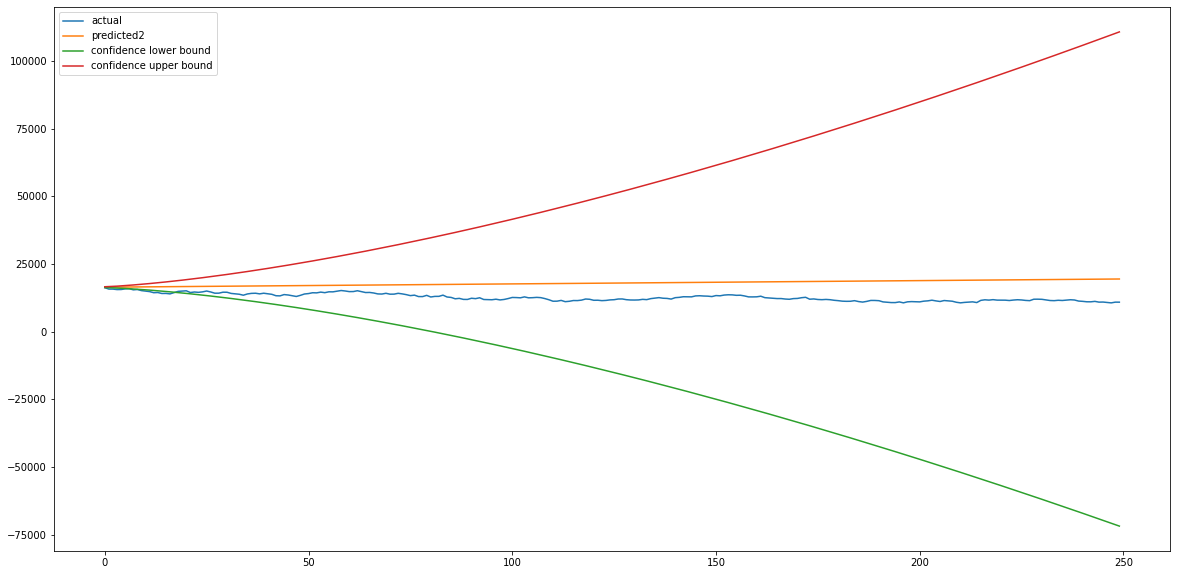

In [74]:
# let's quickly visualize the forecast
xvalid = pd.DataFrame(xvalid, columns = ['actual'])
xvalid['predicted2'] = preds2.reset_index(drop=True)
xvalid['confidence lower bound'] = conf_int2[:, :1]
xvalid['confidence upper bound'] = conf_int2[:, 1:]
xvalid.plot()

<AxesSubplot:>

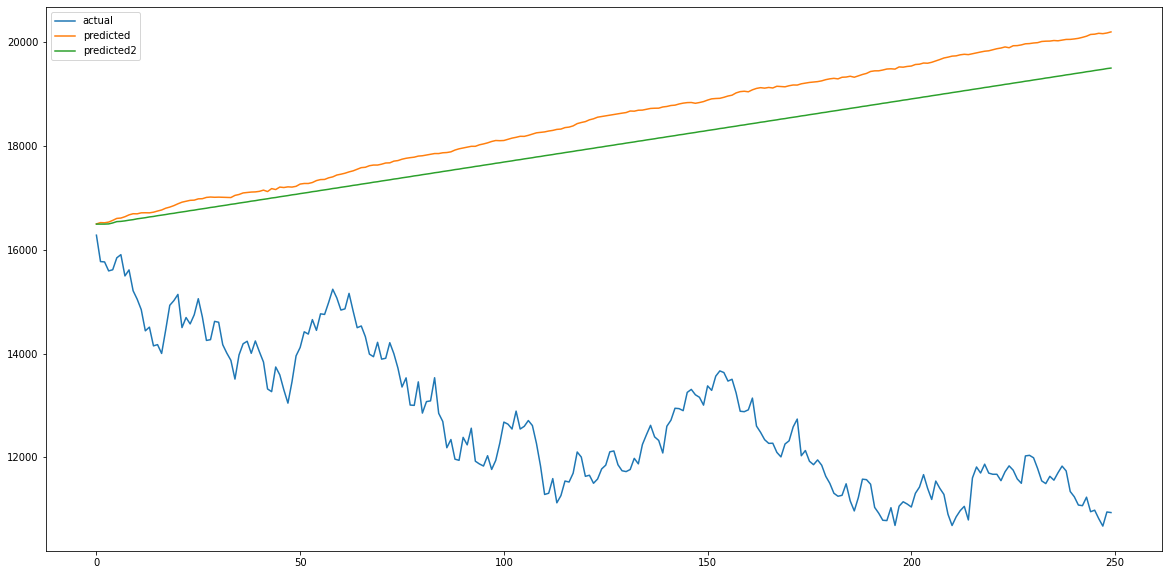

In [57]:
# let's quickly visualize the forecast
xvalid = pd.DataFrame(xvalid, columns = ['actual'])
xvalid['predicted'] = preds.reset_index(drop=True)
xvalid['predicted2'] = preds2.reset_index(drop=True)
xvalid.plot()

In [129]:
# we split the data into training and validation, leaving out the last year as holdout
xtrain2, xvalid2 = model_selection.train_test_split(nasdaq_ohlc_df['Close'], test_size = 50)

In [54]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe3 = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=5)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe3.fit(xtrain2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=81255.843, Time=6.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81332.497, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=81257.114, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=81259.999, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81333.013, Time=3.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=81257.840, Time=1.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=81257.901, Time=2.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=81255.342, Time=5.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=81253.300, Time=6.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=81253.674, Time=0.88 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=81255.941, Time=2.68 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=81257.137, Time=1.33 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=81253.930, Time=1.58 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=81103.324, Time=18.50 sec
 ARIMA(5,1,2)(0,0,

Pipeline(steps=[('fourier', FourierFeaturizer(m=5)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

In [130]:
# we compute predictions from the pipeline object
preds3, conf_int3 = pipe3.predict(n_periods= xvalid2.shape[0], return_conf_int=True)

In [131]:
xvalid2.head(), xvalid2.tail(), preds3.head(), preds3.tail()

(7000    11046.709961
 7001    11310.330078
 7002    11430.259766
 7003    11669.990234
 7004    11405.900391
 Name: Close, dtype: float64,
 7045    10985.450195
 7046    10822.509766
 7047    10679.339844
 7048    10951.049805
 7049    10939.759766
 Name: Close, dtype: float64,
 7000    11085.265966
 7001    11088.083355
 7002    11107.675510
 7003    11069.950140
 7004    11117.881220
 dtype: float64,
 7045    11100.795994
 7046    11099.772842
 7047    11098.590111
 7048    11100.964031
 7049    11099.059775
 dtype: float64)

<AxesSubplot:>

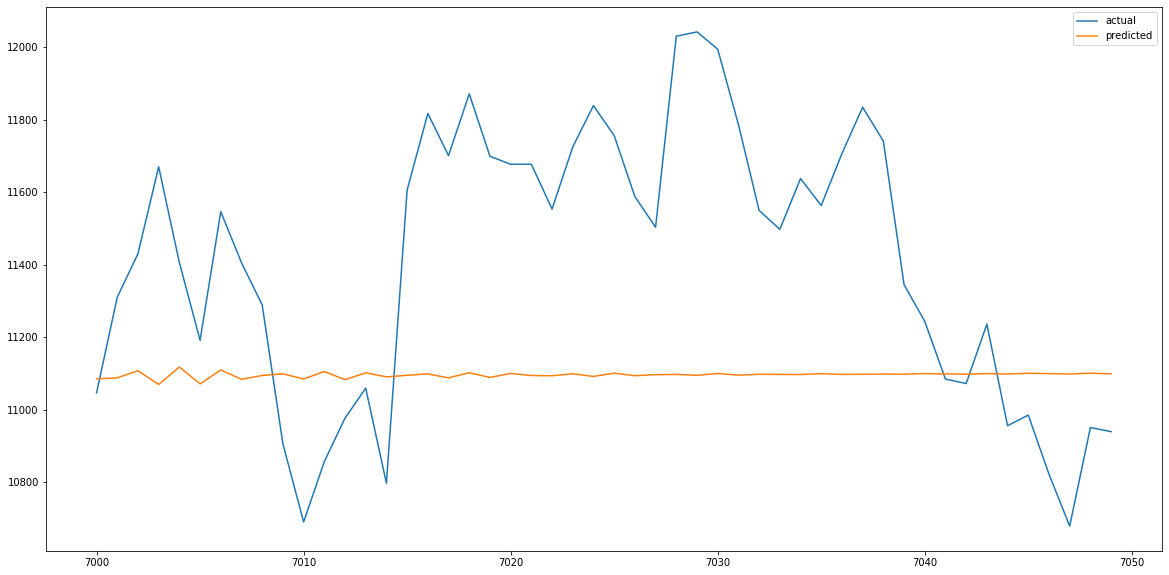

In [132]:
# let's quickly visualize the forecast
xvalid2 = pd.DataFrame(data={
    'actual' : xvalid2,
    'predicted': preds3
})
xvalid2.plot()

In [135]:
# we split the data into training and validation, we are interested in the next 5 bussines days
xtrain3, xvalid3 = model_selection.train_test_split(nasdaq_ohlc_df['Close'], test_size = 5)

In [77]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe4 = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe4.fit(xtrain3)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=82096.941, Time=7.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82167.440, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82098.476, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=82099.959, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82167.767, Time=2.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=82100.878, Time=4.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=82101.129, Time=2.86 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=82096.637, Time=13.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=82094.638, Time=5.87 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=82095.330, Time=0.88 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=82097.143, Time=1.56 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=82099.947, Time=0.73 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=82095.050, Time=1.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=81948.812, Time=16.97 sec
 ARIMA(5,1,2)(0,0

Pipeline(steps=[('fourier', FourierFeaturizer(m=4)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

In [136]:
# we compute predictions from the pipeline object
preds4, conf_int4 = pipe4.predict(n_periods= xvalid3.shape[0], return_conf_int=True)

<AxesSubplot:>

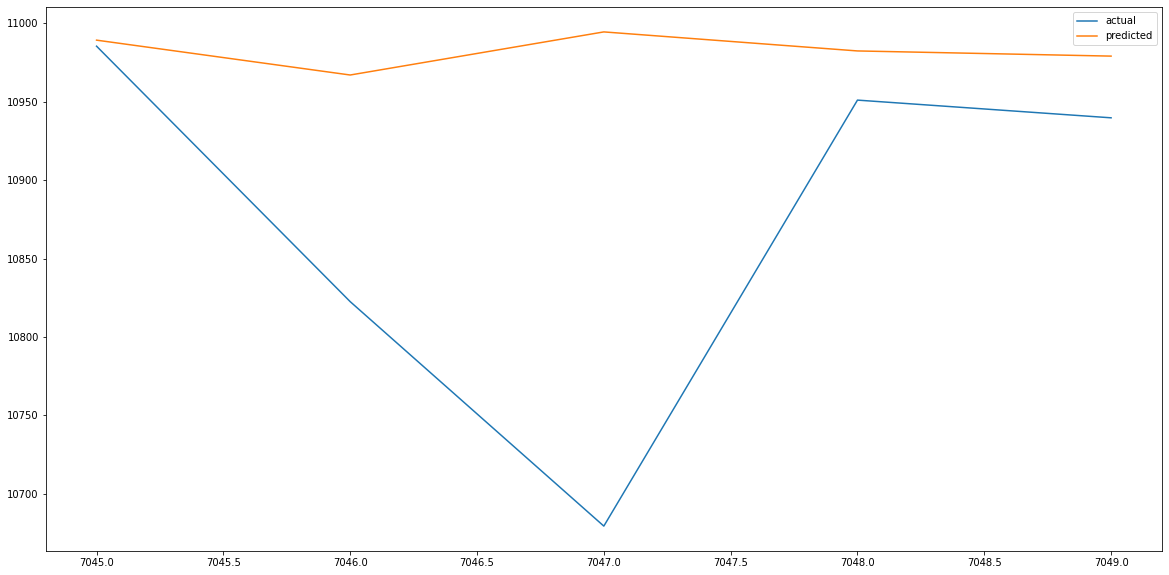

In [137]:
# let's quickly visualize the forecast
xvalid3 = pd.DataFrame(data={
    'actual' : xvalid3,
    'predicted': preds4
})
xvalid3.plot()